# Loading libs and data

In [366]:
'''
loading libs
'''
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [84]:
'''
loading images
'''
nevus_filepath = 'data/0/'
melanoma_filepath = 'data/1/'

nevus_files = [f for f in os.listdir(nevus_filepath) if os.path.isfile(nevus_filepath+f)]
melanoma_files = [f for f in os.listdir(melanoma_filepath) if os.path.isfile(melanoma_filepath+f)]
# sort filenames
nevus_files = sorted(nevus_files)
melanoma_files = sorted(melanoma_files)

N = 100
nevus_imgs = [plt.imread(os.path.join(nevus_filepath, nevus_files[i])) for i in range(N)]
melanoma_imgs = [plt.imread(os.path.join(melanoma_filepath, melanoma_files[i])) for i in range(N)]

# resize
nevus_imgs = [cv2.resize(img,(256,256)) for img in nevus_imgs]
melanoma_imgs = [cv2.resize(img,(256,256)) for img in melanoma_imgs]

# Simularity matrix spectral clustering for toy data

In [3]:
'''
Load toy data
'''
# defenetly dots, blobs, skin for nevus
n_dots =  [13,19,33,35,43,63,89]
n_blobs = [0, 1, 3, 7, 20,28,34]
n_skin =  [11,27,44,50,52,68,55]

# defenetly dots, blobs, skin for melanoma
m_dots =  [6,8,15,16,29,34,46]
m_blobs = [1,3,7, 10,11,21,41]
m_skin =  [4,5,9, 13,14,26,40]

n_data = [nevus_imgs[i]/255 for i in n_dots+n_blobs+n_skin] 
m_data = [melanoma_imgs[i]/255 for i in m_dots+m_blobs+m_skin]

all_imgs = n_data+m_data

In [4]:
'''
0. HilbertCurve flatter
'''
from hilbertcurve.hilbertcurve import HilbertCurve

def get_flat_coords(a):
    # Compute HilbertCurve for 256x256 img
    p=9; N=2
    hilbert_curve = HilbertCurve(p, N)
    flat_coords = []
    for ii in range(a**2):
        coords = hilbert_curve.coordinates_from_distance(ii)
    #     print(f'coords(h={ii}) = {coords}')
        flat_coords += [coords]
    flat_coords = np.array(flat_coords)
    return flat_coords

def hilbert_flat(img, flat_coords):
    flatten_image = []
    for x,y in flat_coords:
        flatten_image += [img[x,y]]

    return np.array(flatten_image)

In [ ]:
'''
1. Compute simularity as SSIM 
'''
from skimage.metrics import structural_similarity as ssim

N = len(all_imgs)
sim_mat = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        sim_mat[i,j] = ssim(all_imgs[i], all_imgs[j])

In [153]:
'''
2. compute simularity using distance function
'''
import scipy.spatial.distance as d #euclidean, minkowski, pdist, squareform

from scipy.signal import coherence
import pandas as pd

#---------------BAD--------------
def similarity_cityblock(u,v):
    return d.cityblock(u,v)
def similarity_coherence(u,v):
    f, cxy = coherence(u,v, nperseg=1024)
    return np.sum(cxy)/len(cxy)
def similarity_braycurtis(u,v):
    return d.braycurtis(u,v)
def similarity_chebyshev(u,v):
    return d.chebyshev(u,v)

#---------------GOOD---------------

def similarity_euclidean(u,v):
    return 1/(1+d.euclidean(u,v))

def similarity_minkowski(u,v):
    return d.minkowski(u,v)

def similarity_canberra(u,v):
    return d.canberra(u,v)


def similarity_correlation(u,v):
    # Good for 2 classes (dots and blobs)
    return d.correlation(u,v)

def similarity_cosine(u,v):
    # VERY good for 2 classes
    return d.cosine(u,v)

def similarity_jensenshannon(u,v):
    # VERY good for 2 classes
    return d.jensenshannon(u,v)


def similarity_sqeuclidean(u,v):
    # same as Minkowski
    return d.sqeuclidean(u,v)


def similarity_wminkowski(u,v):
    return d.wminkowski(u,v,5,np.ones(len(u)))

# def similarity_mahalanobis(u,v):
#     covariance = np.cov(u,v)
#     return d.mahalanobis(u,v,covariance)

# def similarity_(u,v):
#     return

fc = get_flat_coords(256)
f_all_imgs = [hilbert_flat(img, fc) for img in all_imgs]

data = pd.DataFrame(np.array(f_all_imgs))

dists = d.pdist(data, similarity_wminkowski)
sim_mat = pd.DataFrame(d.squareform(dists), columns=data.index, index=data.index)

plt.matshow(sim_mat,cmap=plt.cm.Blues)

KeyboardInterrupt: 

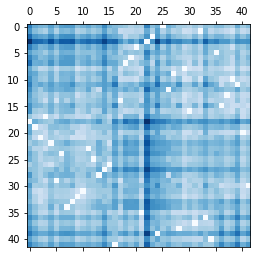

In [79]:
from sklearn.cluster import SpectralCoclustering

model = SpectralCoclustering(n_clusters=3, random_state=42)

sm_data = sim_mat.values
model.fit(sm_data)
# score = consensus_score(model.biclusters_,
#                         (rows[:, row_idx], columns[:, col_idx]))

fit_data = sm_data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)

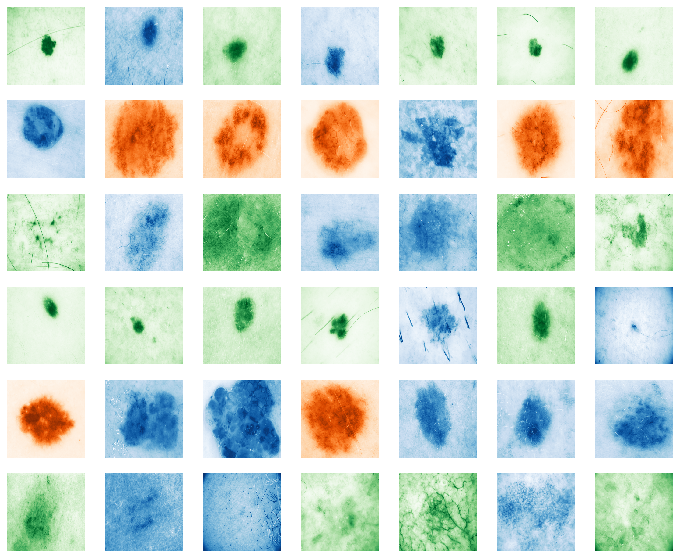

In [80]:
model.row_labels_

k = 0

fig, ax = plt.subplots(6,7, figsize=(12,10))
for i in range(6):
    for j in range(7):
        if model.row_labels_[k] == 0:
            ax[i,j].imshow(all_imgs[k], 'Blues_r')
        if model.row_labels_[k] == 1:
            ax[i,j].imshow(all_imgs[k], 'Greens_r')
        if model.row_labels_[k] == 2:
            ax[i,j].imshow(all_imgs[k], 'Oranges_r')
        if model.row_labels_[k] == 3:
            ax[i,j].imshow(all_imgs[k], 'Purples_r')
        ax[i,j].axis('off')
        k+=1
            

# Voting system

In [85]:
'''
Get all images
'''

all_imgs = nevus_imgs + melanoma_imgs

fc = get_flat_coords(256)
f_all_imgs = [hilbert_flat(img/255, fc) for img in all_imgs]

In [154]:
from sklearn.metrics.pairwise import pairwise_distances
data = pd.DataFrame(np.array(f_all_imgs))

# print('Similarity correlation')
# cor_sim_mat = pairwise_distances(data, metric=similarity_correlation, n_jobs = -1)

# print('Similarity cosine')
# cos_sim_mat = pairwise_distances(X=data, metric=similarity_cosine, n_jobs = -1)

# print('Similarity jensenshannon')
# jsh_sim_mat = pairwise_distances(X=data, metric=similarity_jensenshannon, n_jobs = -1)

# print('Similarity canberra')
# car_sim_mat = pairwise_distances(X=data, metric=similarity_canberra, n_jobs = -1)

print('Similarity euclidean')
euc_sim_mat = pairwise_distances(X=data, metric=similarity_euclidean, n_jobs = -1)

print('Done')

Similarity euclidean
Done


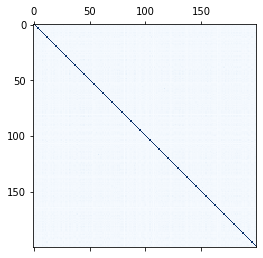

In [155]:
plt.matshow(euc_sim_mat, cmap=plt.cm.Blues)

In [156]:
from sklearn.cluster import SpectralCoclustering

# model_cor = SpectralCoclustering(n_clusters=2, random_state=42)
# model_cos = SpectralCoclustering(n_clusters=2, random_state=42)
# model_jsh = SpectralCoclustering(n_clusters=2, random_state=42)
# model_car = SpectralCoclustering(n_clusters=3, random_state=42)
model_euc = SpectralCoclustering(n_clusters=3, random_state=42)

# model_cor.fit(cor_sim_mat)
# model_cos.fit(cos_sim_mat)
# model_jsh.fit(jsh_sim_mat)
# model_car.fit(car_sim_mat)
model_euc.fit(euc_sim_mat)

SpectralCoclustering(init='k-means++', mini_batch=False, n_clusters=3,
                     n_init=10, n_jobs=None, n_svd_vecs=None, random_state=42,
                     svd_method='randomized')

In [157]:
# fit_cor = cor_sim_mat[np.argsort(model_cor.row_labels_)]
# fit_cor = fit_cor[:, np.argsort(model_cor.column_labels_)]

# fit_cos = cos_sim_mat[np.argsort(model_cor.row_labels_)]
# fit_cos = fit_cos[:, np.argsort(model_cor.column_labels_)]

# fit_jsh = jsh_sim_mat[np.argsort(model_jsh.row_labels_)]
# fit_jsh = fit_jsh[:, np.argsort(model_jsh.column_labels_)]

# fit_car = car_sim_mat[np.argsort(model_car.row_labels_)]
# fit_car = fit_car[:, np.argsort(model_car.column_labels_)]

fit_euc = euc_sim_mat[np.argsort(model_euc.row_labels_)]
fit_euc = fit_euc[:, np.argsort(model_euc.column_labels_)]

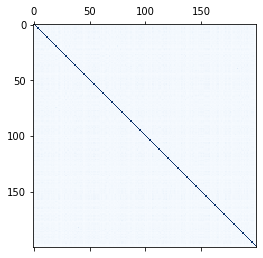

In [158]:
plt.matshow(fit_euc, cmap=plt.cm.Blues)

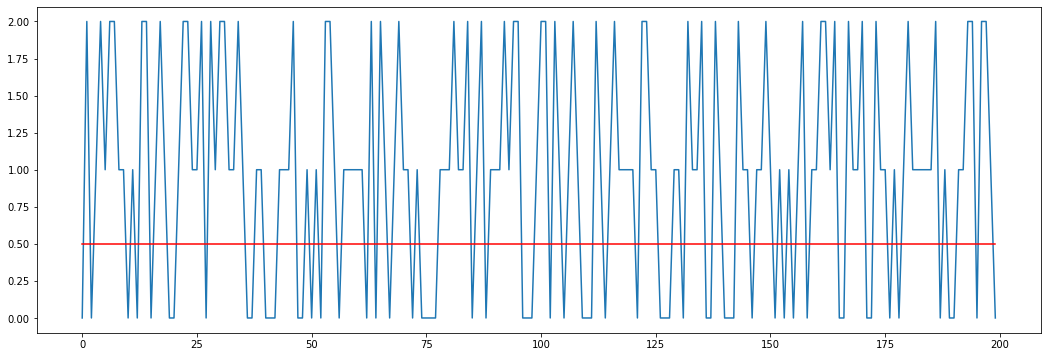

In [159]:
# vote = np.round((model_jsh.row_labels_+model_cos.row_labels_+model_cor.row_labels_)/3)
# vote = np.round((model_jsh.row_labels_+model_cos.row_labels_)/2)
vote = model_car.row_labels_
# vote = model_cos.row_labels_

plt.figure(figsize=(18,6))
# plt.plot(model_cor.row_labels_)
# plt.plot(model_cos.row_labels_)
# plt.plot(model_jsh.row_labels_)
plt.plot(vote)
plt.plot(np.zeros(200)+0.5, 'r')



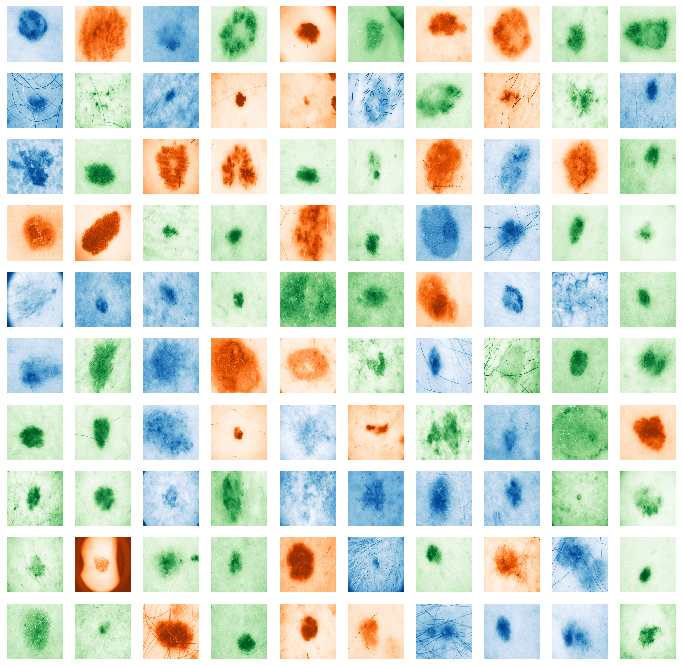

In [160]:
fig, ax = plt.subplots(10,10, figsize=(12,12))

k = 0
for i in range(10):
    for j in range(10):
        if vote[k] == 0:
            ax[i,j].imshow(all_imgs[k], 'Blues_r')
        if vote[k] == 1:
            ax[i,j].imshow(all_imgs[k], 'Greens_r')
        if vote[k] == 2:
            ax[i,j].imshow(all_imgs[k], 'Oranges_r')
            
        ax[i,j].axis('off')
        k += 1

# NN classification

In [831]:
'''
generating data
'''
import skimage.draw as d
   
def get_circle(img):
    radius = np.random.randint(img.shape[0]/5,img.shape[0]/2)
    shift = 50
    center = (np.random.randint(0+shift,img.shape[0]-shift),
              np.random.randint(0+shift,img.shape[1]-shift))
    

    x, y = np.indices((img.shape[0], img.shape[1]))
    circle = (x - center[0]) ** 2 + (y - center[1]) ** 2 < radius ** 2
    return img + circle

def get_line(img):
    x1 = np.random.randint(0, img.shape[0])
    x2 = np.random.randint(0, img.shape[1])
    y1 = np.random.randint(0, img.shape[0])
    y2 = np.random.randint(0, img.shape[1])
    
    rr, cc, val = d.line_aa(x1,x2,y1,y2)
    img[rr,cc] = val
    
    return img

def get_noise(img):
    noise = np.random.normal(0.5,0.5/3,img.shape)
    return img+noise
#---------------------------------------------------------------------------------
g_size = (256, 256)

circles = []
for i in range(1000):
    g_img = np.zeros(g_size)
    g_img = get_noise(get_circle(g_img))
    g_img = (g_img - g_img.min())/(g_img.max() - g_img.min())
    circles += [1 - g_img]
    
lines = []
for i in range(1000):
    g_img = np.zeros(g_size)
    n = np.random.randint(23)+1
    for j in range(n):
        g_img = get_line(g_img)
    g_img = get_noise(g_img)
    g_img = (g_img - g_img.min())/(g_img.max() - g_img.min())
    lines += [1 - g_img]
    
white = []
black = []
noise = []
for i in range(500):
    g_img = np.zeros(g_size)
    white += [1 - g_img]
    black += [g_img]
    g_img = get_noise(g_img)
    g_img = (g_img - g_img.min())/(g_img.max() - g_img.min())
    noise += [1 - g_img]


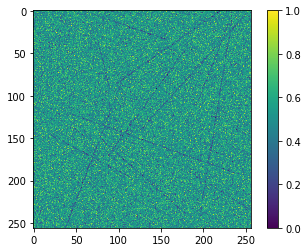

In [820]:
plt.imshow(lines[23])
plt.colorbar()

In [832]:
# Generate noisy dots
n_dots = []

for i in range(5000):
    g_img = np.zeros(g_size)
    g_img = get_line(get_ellipse(g_img))
    n = np.random.randint(20)+1
    for _ in range(n):
        g_img = get_line(g_img)
    g_img = get_noise(g_img)    
    # Normalization
    g_img = (g_img - g_img.min())/(g_img.max() - g_img.min())
    g_img = 1 - g_img
    n_dots += [g_img]


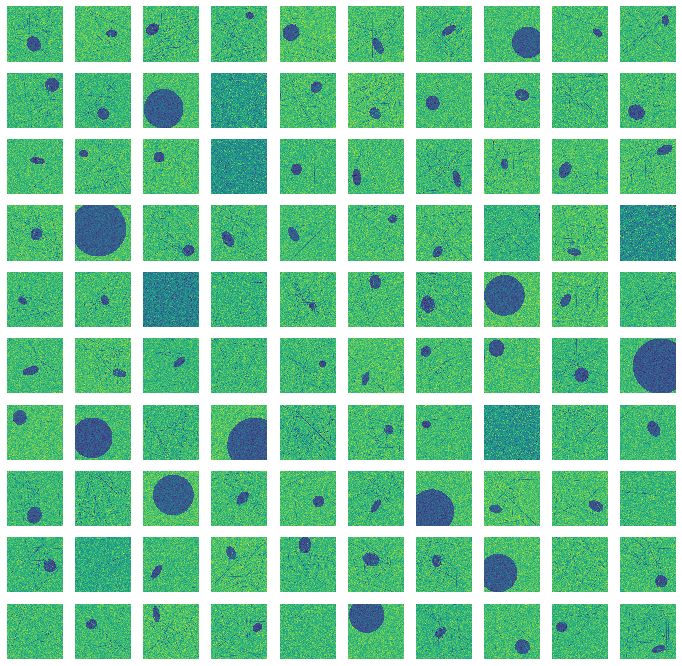

In [835]:
fig, ax = plt.subplots(10,10, figsize=(12,12))
k = 0
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(X_train[k][:,:,0], vmax=1,vmin=0)
        ax[i,j].axis('off')
        k+=1


In [742]:
def get_ellipse(img):
    shift = 40
    x1 = np.random.randint(0+shift, img.shape[0] - shift)
    x2 = np.random.randint(0+shift, img.shape[1] - shift)
    y1 = np.random.randint(15, 40)
    y2 = np.random.randint(15, 40)
    r = np.random.randint(0, 360)
    rr,cc = d.ellipse(x1,x2,y1,y2,rotation=np.deg2rad(r))
    img[rr,cc] = 1
    return img
    
# generate dots
dots = []
for i in range(3500):
    g_img = np.zeros(g_size)
    g_img = get_ellipse(g_img)
    dots += [1 - g_img] 

# plt.figure(figsize=(5,5))
# plt.imshow(g_img)
# plt.colorbar()

In [833]:
# Get all data 
# X = np.array(circles+lines+white+black+noise + n_dots)
X = np.array(circles+lines+noise + n_dots)
y = np.zeros(X.shape[0])
y[3500:] = 1
print(X.shape)

(7500, 256, 256)


In [834]:
'''
Split data
'''
from sklearn.model_selection import train_test_split

X = np.array([img.reshape(256,256,1) for img in X])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [836]:
import tensorflow

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

tensorflow.debugging.set_log_device_placement(True)
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpus[0], True)

1.15.2
Num GPUs Available:  1


In [837]:
'''
Define plot training function
'''
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [843]:
# My model
model = models.Sequential()
model.add(layers.Conv2D(32, (4,4), activation='relu', input_shape=(256,256,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(256,256,1)))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(32,(2,2), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(64,(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))
# # model.add(layers.Conv2D(128,(3,3), activation='relu'))
# # model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.6))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))


model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 253, 253, 32)      544       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 128)     

In [844]:
history = model.fit(
    X_train,
    y_train,
    epochs = 4,
    validation_split=0.2)

Train on 4200 samples, validate on 1050 samples
Epoch 1/4
4200/4200 [==============================] - 10s 2ms/sample - loss: 0.6807 - acc: 0.5748 - val_loss: 0.5758 - val_acc: 0.7067
Epoch 2/4
4200/4200 [==============================] - 8s 2ms/sample - loss: 0.6513 - acc: 0.6036 - val_loss: 0.6819 - val_acc: 0.5371
Epoch 3/4
4200/4200 [==============================] - 8s 2ms/sample - loss: 0.6785 - acc: 0.5757 - val_loss: 0.6728 - val_acc: 0.5400
Epoch 4/4
4200/4200 [==============================] - 8s 2ms/sample - loss: 0.6676 - acc: 0.6002 - val_loss: 0.6593 - val_acc: 0.6133


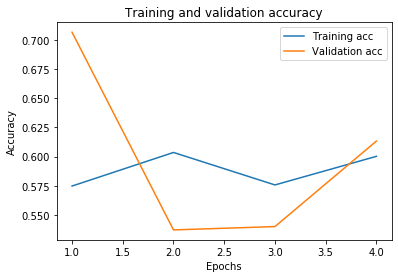

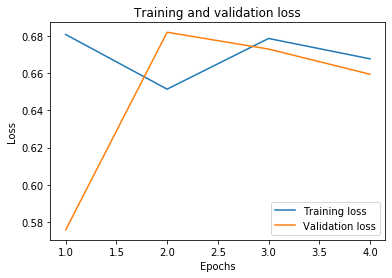

2250/2250 [==============================] - 2s 1ms/sample - loss: 0.6532 - acc: 0.6120
test acc: 0.612
test loss: 0.6531777202818129


In [845]:
plot_history(history)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test acc:", test_acc)
print("test loss:", test_loss)

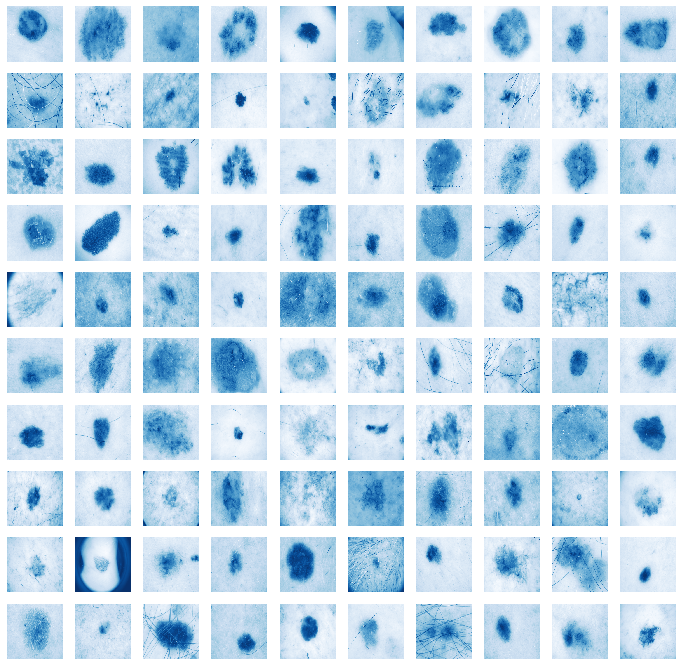

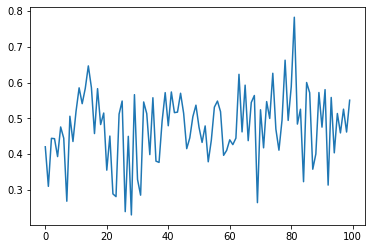

In [846]:
'''
Apply model to real data
'''
data = np.array([img.reshape(256,256,1)/255 for img in nevus_imgs]) # nevus_imgs
n_classes = model.predict(data)

dots_classes = n_classes > 0.9

fig, ax = plt.subplots(10,10, figsize=(12,12))
k = 0
for i in range(10):
    for j in range(10):
        if dots_classes[k]:
            ax[i,j].imshow(nevus_imgs[k], 'Greens_r')
        else:
            ax[i,j].imshow(nevus_imgs[k], 'Blues_r')
        ax[i,j].axis('off')
        k+=1
plt.figure()
plt.plot(n_classes)

# K-means SCC

In [161]:
# Define clustering of colors in image
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

def cluster_image(img, n_colors):
    if img.max() > 1:
        img = img / 255
        
    image_array = img.reshape(img.shape[0]*img.shape[1],1)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    # Get labels for all points
    labels = kmeans.predict(image_array)

    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((w, h))
        label_idx = 0
        for i in range(w):
            for j in range(h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image
    return recreate_image(kmeans.cluster_centers_, labels, img.shape[0], img.shape[1])

In [690]:
'''
make clustered images. For BIG data
'''
n_colors = 3
nc_imgs = []

for img in nevus_imgs:
    nc_img = cluster_image(img, n_colors)
    nc_imgs += [nc_img]
    
mc_imgs = []
for img in melanoma_imgs:
    mc_img = cluster_image(img, n_colors)
    mc_imgs += [mc_img]

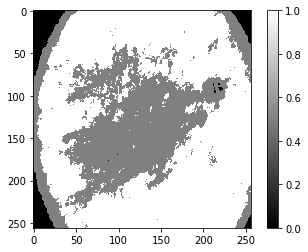

In [691]:
'''
Scaling all values into 3 values
'''
def map_3color_imgs(c_imgs):
    map_val = [0, 0.5, 1]
    new_imgs = []
    for i in range(len(c_imgs)): 
        img = c_imgs[i]
        u_val = sorted(np.unique(img))
        img[img == u_val[0]] = map_val[0]
        img[img == u_val[1]] = map_val[1]
        img[img == u_val[2]] = map_val[2]

        new_imgs += [img]
    return new_imgs

n_imgs = map_3color_imgs(nc_imgs)
m_imgs = map_3color_imgs(mc_imgs)

plt.imshow(n_imgs[40], 'gray')
plt.colorbar()

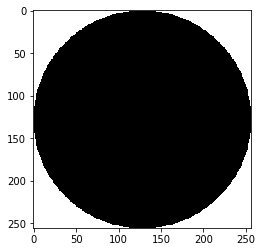

In [329]:
def get_circle(size, radius=-1):
    # if radius not specified, half of size[0]
    mask = np.zeros(size)+1
    l=256
    x, y = np.indices((l, l))

    center = (size[0]//2,size[1]//2)
    if radius == -1:
        radius = size[0]//2

    circle = (x - center[0]) ** 2 + (y - center[1]) ** 2 < radius ** 2
    circle =  1 - circle

    return mask * circle
    
plt.imshow(get_circle((256,256)), 'gray', vmax=1, vmin=0)

In [328]:
type(256//2)

int

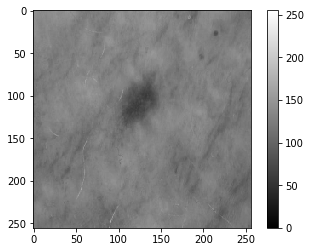

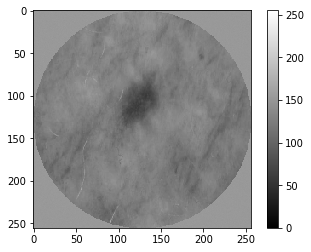

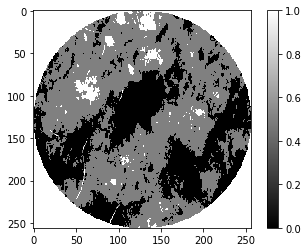

In [365]:
def black_corners_removal(img, mask, threshold=150):
    outside = (img+0.01) * mask 
    inside = img * (1 - mask) 
    
    light_outside = outside.copy()
    light_outside[outside < threshold] = 0

    std = np.std(light_outside[light_outside>0]) / 2
    m = np.mean(light_outside[light_outside>0])
    noise = np.random.normal(m, std, (256,256))
    
    
    dark_outside = outside.copy()
    dark_outside[outside > threshold] = 0
    dark_outside[dark_outside>0] = noise[dark_outside>0]
    
    new_outside = dark_outside+light_outside

    return new_outside+inside

img = nevus_imgs[12]
mask = get_circle(img.shape)
new_img = black_corners_removal(img, mask, 150)

# plt.figure()
plt.imshow(img, 'gray',vmax=255, vmin=0)
plt.colorbar()
plt.figure()
plt.imshow(new_img, 'gray',vmax=255, vmin=0)
plt.colorbar()
plt.figure()
plt.imshow(map_3color_imgs([cluster_image(new_img,3)])[0],'gray',vmax=1, vmin=0)
plt.colorbar()